# [RSNA Pneumonia Detection Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge)

### Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:

from fastai.vision import *
import pydicom
import imageio

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

torch.backends.cudnn.benchmark=True

from scipy.special import expit

In [5]:
PATH = Path('data')

### Functions

In [29]:
def hw_bb(row): return np.array([row['y'], row['x'], row['height']+row['y'], row['width']+row['x']])

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    parsed = collections.defaultdict(lambda:{'dicom': None,
                                        'png': None,     
                                        'label': None,
                                        'boxes': []})
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        parsed[pid]['dicom'] = str(PATH/'stage_2_train_images'/f'{pid}.dcm')
        parsed[pid]['png'] = str(PATH/'train_pngs/orig'/f'{pid}.png')
        parsed[pid]['label'] = row['Target']
        parsed[pid]['boxes'].append(hw_bb(row))

    return parsed

def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[-2:]-x[:2]), reverse=True)
    return [b[0]]

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, col='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=col, lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14, col='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=col, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_im(im, ann, ax=None):
    ax = show_img(im, figsize=(12,6), ax=ax)
    l = cats[ann['label']]
    for b in ann['boxes']:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], l, sz=16)
        
def draw_idx(im_a, ax=None):
    dcm_data = pydicom.read_file(im_a['dicom'])
    im = dcm_data.pixel_array
    draw_im(im, im_a, ax=ax)
    
def from_dicom_to_png(parsed):
    for k, v in parsed.items():
        dcm_data = pydicom.read_file(v['dicom'])
        im = dcm_data.pixel_array
        imageio.imwrite(v['png'], im)
        
class ObjDetDataset(Dataset):
    def __init__(self, ds, y2): 
        self.ds = ds 
        self.y2 = y2
    
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        return (x, (y, self.y2[i]))

### Data loading and pre-processing

In [30]:
labs = pd.read_csv(PATH/'stage_2_train_labels.csv')
labs.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [31]:
labs.x.fillna(0, inplace=True)
labs.y.fillna(0, inplace=True)
labs.width.fillna(1023, inplace=True)
labs.height.fillna(1023, inplace=True)

labs.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,1023.0,1023.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,1023.0,1023.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,1023.0,1023.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,1023.0,1023.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [32]:
parsed = parse_data(labs)

parsed_lrg = {a: {'dicom': b['dicom'],
                  'png': b['png'],
                  'label': b['label'],
                  'boxes': get_lrg(b['boxes'])} for a, b in parsed.items()}

In [33]:
len(parsed)

26684

In [34]:
cats = {0: 'normal', 1: 'pneumonia'}

In [35]:
patient = '3b081d12-6804-4a33-85cd-712a886e4e01'
parsed[patient]

{'dicom': 'data/stage_2_train_images/3b081d12-6804-4a33-85cd-712a886e4e01.dcm',
 'png': 'data/train_pngs/orig/3b081d12-6804-4a33-85cd-712a886e4e01.png',
 'label': 1,
 'boxes': [array([211., 590., 478., 768.]), array([241., 227., 737., 445.])]}

In [36]:
parsed_lrg[patient]

{'dicom': 'data/stage_2_train_images/3b081d12-6804-4a33-85cd-712a886e4e01.dcm',
 'png': 'data/train_pngs/orig/3b081d12-6804-4a33-85cd-712a886e4e01.png',
 'label': 1,
 'boxes': [array([241., 227., 737., 445.])]}

In [37]:
bb = parsed_lrg[patient]['boxes'][0]
bb_transformed = bb_hw(bb)
bb_original = labs.loc[labs.patientId == patient,:].iloc[1]

print(f'Top-Left-Bottom-Right BB: {bb}')
print(f'Transformed Top-Left-WH: {bb_transformed}')
print(f'Original Top-Left-WH: [{bb_original.x} {bb_original.y} {bb_original.width} {bb_original.height}]')

Top-Left-Bottom-Right BB: [241. 227. 737. 445.]
Transformed Top-Left-WH: [227. 241. 218. 496.]
Original Top-Left-WH: [227.0 241.0 218.0 496.0]


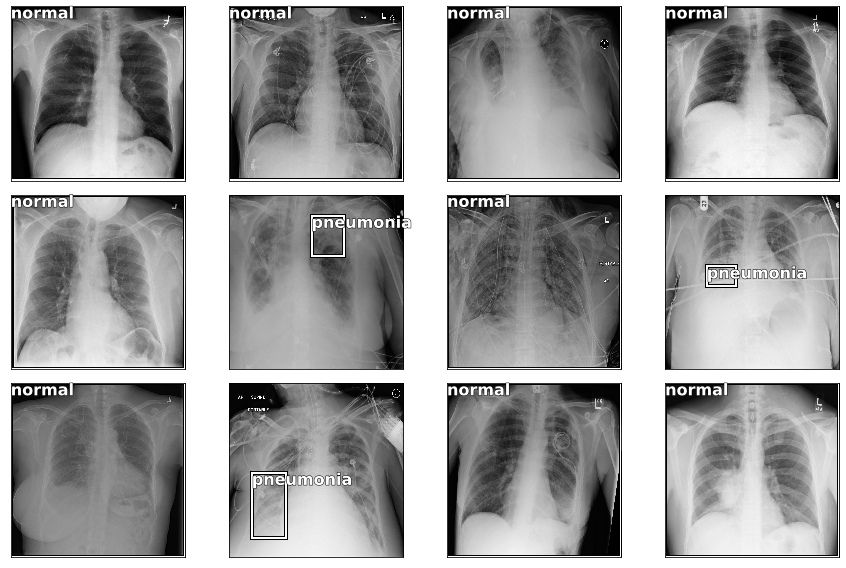

In [38]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    patient = labs.patientId.sample().values[0]
    draw_idx(parsed_lrg[patient], ax=ax)

plt.tight_layout()

In [39]:
(PATH/'tmp').mkdir(exist_ok=True)

CSV = PATH/'tmp/lrg.csv'
BB_CSV = PATH/'tmp/bb.csv'

In [40]:
df = pd.DataFrame({'fn': [parsed_lrg[o]['png'] for o in parsed_lrg],
                   'cat': [parsed_lrg[o]['label'] for o in parsed_lrg],
                   'bbox': [' '.join(str(p) for p in parsed_lrg[o]['boxes'][0]) for o in parsed_lrg]})

In [41]:
df.head()

,fn,cat,bbox
0,data/train_pngs/orig/0004cfab-14fd-4e49-80ba-6...,0,0.0 0.0 1023.0 1023.0
1,data/train_pngs/orig/00313ee0-9eaa-42f4-b0ab-c...,0,0.0 0.0 1023.0 1023.0
2,data/train_pngs/orig/00322d4d-1c29-4943-afc9-b...,0,0.0 0.0 1023.0 1023.0
3,data/train_pngs/orig/003d8fa0-6bf1-40ed-b54c-a...,0,0.0 0.0 1023.0 1023.0
4,data/train_pngs/orig/00436515-870c-4b36-a041-d...,1,152.0 562.0 605.0 818.0


In [42]:
df.cat.sum()/df.shape[0]

0.225303552690751

In [43]:
li = [str(el) for el in list((PATH/'train_pngs').iterdir())]
len(li)

1

In [44]:
dfs = df.loc[df.fn.isin(li),:]
dfs.shape

(0, 3)

In [45]:
dfs.cat.sum()/dfs.shape[0]

/home/sahand/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in long_scalars
  """Entry point for launching an IPython kernel.


nan

In [47]:
dfs[['fn', 'cat']].to_csv(CSV, index=False)
dfs[['fn', 'bbox']].to_csv(BB_CSV, index=False)

# Single Object Detection modeling pipeline

### Figuring out input dimension of model to stack on top of CNN

In [22]:
f_model = resnet34
sz=512
bs=8

tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, 'train_pngs', CSV, tfms=tfms, bs=bs)
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 512, 512]),
                           ('output_shape', [-1, 64, 256, 256]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 256, 256]),
                           ('output_shape', [-1, 64, 256, 256]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 256, 256]),
                           ('output_shape', [-1, 64, 256, 256]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 256, 256]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 12

The output dimension of the last Conv Block (`BasicBlock-122`) is `[-1, 512, 16, 16]`.

We will make use of the very handy `head` concept within the fast.ai library which allows to truncate the pre-trained network to its last conv layer and stack a custom model on top. 

The input shape of the custom `head` will be `512 * 16 * 16 = 131072` 

In [23]:
input_to_top_model = 512 * 16 * 16

### Putting together the network

In [24]:
f_model = resnet34
sz=512
bs=8

val_idxs = get_cv_idxs(len(dfs))

In [25]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [26]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)

In [27]:
md_box = ImageClassifierData.from_csv(PATH, 'train_pngs', BB_CSV, tfms=tfms, bs=bs, continuous=True, val_idxs=val_idxs)

In [28]:
md_class = ImageClassifierData.from_csv(PATH, 'train_pngs', CSV, tfms=tfms_from_model(f_model, sz), bs=bs)

In [29]:
trn_ds = ObjDetDataset(md_box.trn_ds, md_class.trn_y)
val_ds = ObjDetDataset(md_box.val_ds, md_class.val_y)

In [30]:
trn_ds[0][1]

(array([  0.,   1., 508., 509.], dtype=float32), 0)

In [31]:
md_box.trn_dl.dataset = trn_ds
md_box.val_dl.dataset = val_ds

In [32]:
x, y = next(iter(md_box.trn_dl))

In [33]:
x.shape

torch.Size([8, 3, 512, 512])

In [34]:
y[0].shape

torch.Size([8, 4])

In [35]:
y[1].shape

torch.Size([8])

### A quick look into augmented data

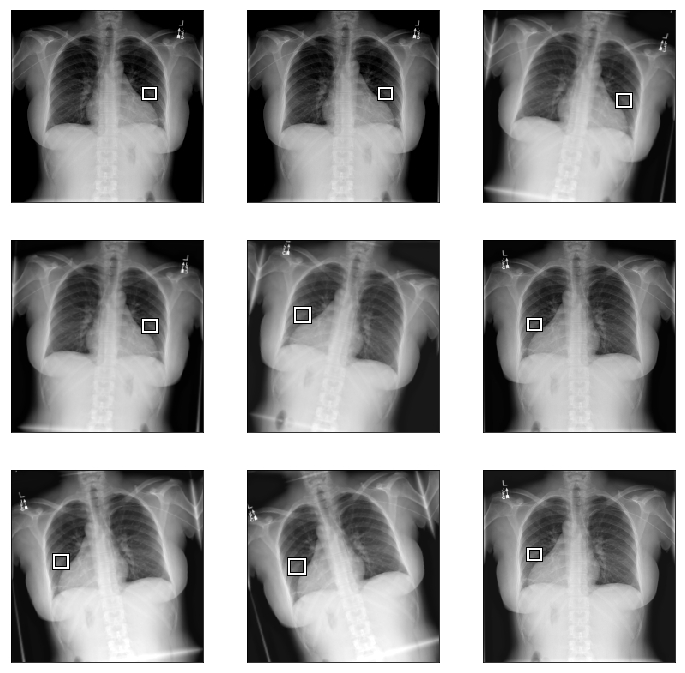

In [304]:
idx = 4
fig,axes = plt.subplots(3,3, figsize=(12,12))
for i,ax in enumerate(axes.flat):
    x, y= next(iter(md_box.aug_dl))
    ima = md_box.val_ds.ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [36]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(input_to_top_model,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md_box, models)
learn.opt_fn = optim.Adam

### How much do we need to multiply the `cross_entropy` to make it comparable to the `f1_loss`?

In [37]:
ratios = []

for i in range(200):
    x, y = next(iter(md_box.trn_dl))
    t = learn.model(V(x))
    
    bb_t,c_t = y
    bb_i,c_i = t[:, :4], t[:, 4:]
    bb_i = F.sigmoid(bb_i)*sz
    
    reg = F.l1_loss(bb_i, V(bb_t)).data.cpu().numpy()
    clas = F.cross_entropy(c_i, V(c_t)).data.cpu().numpy()
    
    ratios.append((reg/clas)[0])

In [38]:
np.mean(ratios)

316.19495

In [39]:
np.median(ratios)

315.9591

In [43]:
scaler = int(np.mean(ratios))

We'll use `scaler` as a multiplier

In [44]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*sz
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*scaler

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*sz
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

### Training

 68%|██████▊   | 887/1304 [02:03<01:08,  6.08it/s, loss=717]

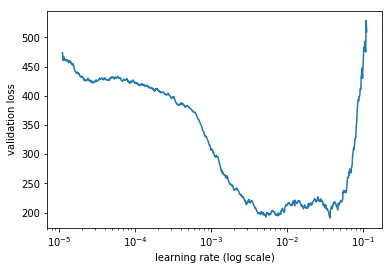

In [45]:
learn.lr_find()
learn.sched.plot()

In [46]:
lr = 1e-3

In [47]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   detn_acc   detn_l1          
    0      174.895291 172.209051 0.812428   41.01609  
    1      171.30719  175.863391 0.81473    40.547041        
    2      174.487408 168.366679 0.813195   40.288797        


[array([168.36668]), 0.8131952435749904, 40.28879699224158]

In [48]:
lrs = np.array([lr/100, lr/10, lr])

 71%|███████▏  | 931/1304 [02:07<00:45,  8.20it/s, loss=594]

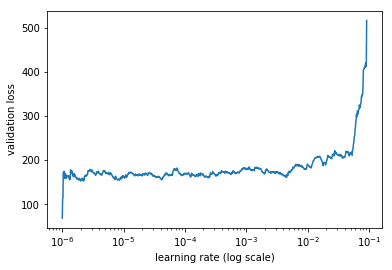

In [49]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [50]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1          
    0      166.229865 167.237234 0.818949   39.871691 
    1      170.003512 173.134646 0.815113   40.367774        
    2      161.637138 166.990009 0.819333   39.899834        
    3      164.348357 167.911453 0.818949   39.78808         
    4      173.755998 168.717585 0.817798   40.990115        


[array([168.71759]), 0.8177982355426178, 40.99011473935548]

In [51]:
learn.unfreeze()

In [52]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1          
    0      147.097251 166.964797 0.823552   39.642597 
    1      151.418691 180.631339 0.820483   40.371129        
    2      147.091035 162.245885 0.822401   39.800822        
    3      170.623915 176.742333 0.825086   39.689462        
    4      159.67369  163.620087 0.824319   39.695283        
    5      145.598698 163.272598 0.821634   39.461511        
    6      150.935017 162.213645 0.823552   39.154999        
    7      141.703292 163.0342   0.828539   39.52882         
    8      136.516284 162.597983 0.825086   39.102568        
    9      134.342289 162.261749 0.827771   39.321222        


[array([162.26175]), 0.8277713847562733, 39.321222175617166]

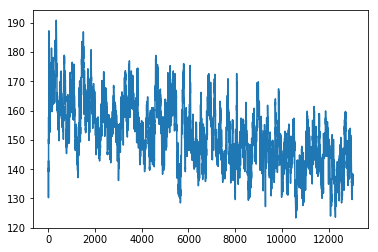

In [53]:
learn.sched.plot_loss()

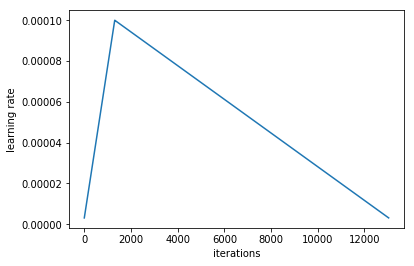

In [54]:
learn.sched.plot_lr()

### Looking at the results

In [211]:
y = learn.predict()

In [301]:
idx = np.random.randint(low=0, high=(len(md_box.val_ds)-1), size=16)

In [302]:
names = md_box.val_ds.ds.fnames[idx]
true_label = [cats[i] for i in md_box.val_ds.y2[idx]]
true_box = md_box.val_ds.ds.y[idx]

pred_label = [cats[i] for i in np.argmax(y[idx, 4:], axis=1)]
pred_box = (expit(y[idx, :4])*1024).astype(int)

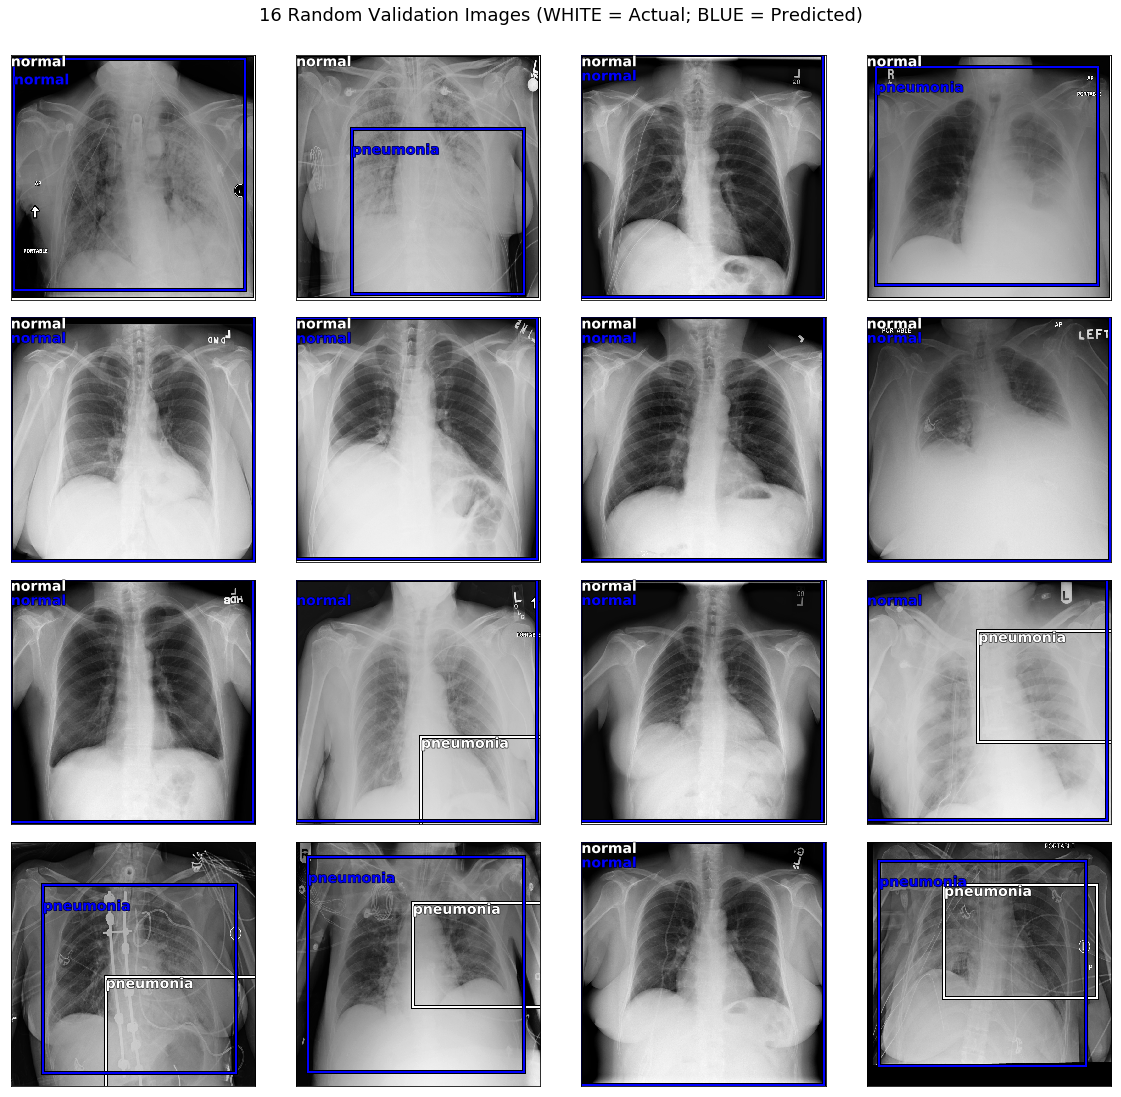

In [308]:
fig,axes = plt.subplots(4,4, figsize=(16,16))

for i,ax in enumerate(axes.flat):
    im = imageio.imread(names[i])
    ax = show_img(im, ax=ax)
    draw_rect(ax, true_box[i])
    draw_rect(ax, pred_box[i], col='blue')
    draw_text(ax, true_box[i][:2], true_label[i])
    draw_text(ax, pred_box[i][:2]+np.array([0,60]), pred_label[i], col='blue')
    
fig.suptitle('16 Random Validation Images (WHITE = Actual; BLUE = Predicted)', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])